# **Банк "Метанпром"*: Анализ оттока клиентов**

**Дополнительные материалы:** [Презентация](https://disk.yandex.ru/i/10BwJb_Q9eeeIw)

**Задача:**
+ Проанализировать клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка

**Описание данных**
+ user_id - идентификатор пользователя,
+ score - балл кредитного скоринга,
+ city - город,
+ gender - пол,
+ age - возраст, 
+ balance - баланс на счёте,
+ products - количество продуктов, которыми пользуется клиент,
+ has_credit_card - есть ли кредитная карта,
+ is_active - флаг активности/неактивности клиента,
+ salary - заработная плата клиента,
+ churn - ушел или нет.

**Этапы анализа**
+ Исследовательский анализ данных
+ Составление портрета клиентов, склонных уходить из банка
+ Сегментация клиентов в зависимости от их склонности к оттоку
+ Формулировка и проверка статистических гипотез

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import pylab
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [3]:
sns.set()

In [4]:
# Функция для предварительного анализа данных
def df_eda(df):
  class color:
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'
  
  def tbl_dict_base(df, col):
    tbl_dict = {}
    tbl_dict['valid'] = (~df[col].isnull()).sum()
    tbl_dict['valid_pct'] = tbl_dict['valid']/len(df)
    tbl_dict['missing'] = (df[col].isnull()).sum()
    tbl_dict['missing_pct'] = tbl_dict['missing']/len(df)
    tbl_dict['unique_values'] = df[col].nunique()
    return tbl_dict

  def display_table(tbl_dict, subset1=['missing', 'missing_pct'], \
                    subset2=['valid_pct', 'missing_pct']):
    tbl_det = pd.DataFrame([tbl_dict])
    tbl_det = (
        tbl_det.style.applymap(lambda x: 'color:red' if x > 0 else 'color:green', 
                              subset=subset1)
        .format('{:0.2%}', subset=subset2).hide(axis='index')
      )
    display(tbl_det)

  pd.set_option('display.max_columns', None)
  print(color.BOLD + 'General information' + color.END)
#   display(df.head())
#   print('')
  display(df.info())
  df_duples = df.copy()
  print('')

#   print(color.BOLD + 'Heatmap - missing values' + color.END)
#   fig, ax = plt.subplots(figsize=(8,5))
#   sns.heatmap(df.isna(), cmap='Blues', cbar=False)
#   plt.show();
  print('')
  print('')
  print(color.BOLD + 'Column stats' + color.END)
  print('')

  missing_cols_cnt = 0
  missing_cols_list = []
  id_duples = 0
  
  for col in df.columns:
    if df[col].dtype == 'object':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      try:
        df[col] = df[col].str.replace('ё','е')
        tbl_dict['case_sensitive_dupl'] = (
          df[col].str.lower().duplicated().sum() - df[col].duplicated().sum()
        )
        if tbl_dict['case_sensitive_dupl'] > 0:
          df_duples[col] = df_duples[col].str.lower()
        
        display_table(tbl_dict, ['missing', 'missing_pct', 'case_sensitive_dupl'])
      
      except:
        print('Dtype check needed')
        display_table(tbl_dict)
            
      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)

      if tbl_dict['unique_values'] > 5:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', col]
        most_common['Most common'] = (
            most_common['Most common']
            .where(most_common['Most common']
                  .isin(df[col].value_counts(normalize=True).head(5).index), 'other')
        )
        most_common = (
            most_common.groupby('Most common', sort=False)[col]
            .agg('sum').to_frame('')
        )

      else:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', '']
        most_common = most_common.set_index('Most common')
      
      display(most_common.style.format('{:0.1%}'))
      print('')

    elif df[col].dtype == 'float' or df[col].dtype == 'int64':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      tbl_dict['zeros'] = len(df[df[col] == 0])
      tbl_dict['negatives'] = len(df[df[col] < 0])
      display_table(tbl_dict)

      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)
      
      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.show();
      tbl_stats = pd.DataFrame({'':[df[col].mean(), df[col].median(), 
                                   df[col].std(), df[col].min(),
                                   df[col].max(), df[col].quantile(0.01),
                                   df[col].quantile(0.99)]})
      tbl_stats.index = ['mean', 'median', 'std', 'min', 'max', 
                         '1st quantile', '99th quantile']
      display(tbl_stats.style.format('{:.2f}'))
      # display(df[col].describe().to_frame('')[1:].style.format("{:.2f}"))
      print('')

    elif df[col].dtype == 'datetime64[ns]':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)

      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)

      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.xticks(rotation=45)
      plt.show();
      display(df[col].apply(['min', 'max', 'mean']).to_frame(''))
      print('')

    elif df[col].dtype == 'bool':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)
      display(df[col].value_counts(normalize=True).to_frame('').style.format('{:0.1%}'))
      
      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)
    
    else:
      print(color.BLUE + col + color.END)
      print('check format')

    if col.lower() == 'id' or col.lower() == 'userid' or col.lower() == 'user_id':
        id_duples = df[col].duplicated().sum()
  
  print(color.BLUE + 'EDA brief' + color.END)
  print('')
  print(f'Rows in dataset: {df.shape[0]}')
  print(f'Columns in dataset: {df.shape[1]}')
  print(f'Number of columns with missing values: {missing_cols_cnt}')
  print('Columns with missing values: ', missing_cols_list)
  print('')

  print(color.BOLD + 'Duplicates in dataset: ' + color.END)
  tbl_dupl = (
      pd.DataFrame({'duples_cnt':[df.duplicated().sum()], 
                    'duples_pct':[df.duplicated().sum()/len(df)],
                    'case_sensitive_duples':[(df_duples.duplicated().sum()-df.duplicated().sum())],
                    'case_sensitive_pct':[(df_duples.duplicated().sum()-df.duplicated().sum())/len(df)], 
                    'id_duples':[id_duples],
                    'id_duples_pct':[id_duples/len(df)]})
      .style.applymap(lambda x: 'color:red' if x > 0 else 'color:green')
      .format('{:.2%}', subset=['duples_pct', 'case_sensitive_pct', 'id_duples_pct'])
  )
  display(tbl_dupl)

In [25]:
df = pd.read_csv('C:/Rabota/IT/Datasets/bank_database.csv') 

In [26]:
df.head()

,user_id,score,city,gender,age,balance,products,has_credit_card,is_active,salary,churn
0,183012,850.0,Рыбинск,Ж,25,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,174.00,1,1,0,67353.16,1


General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          10000 non-null  int64  
 1   score            10000 non-null  float64
 2   city             10000 non-null  object 
 3   gender           10000 non-null  object 
 4   age              10000 non-null  int64  
 5   balance          7705 non-null   float64
 6   products         10000 non-null  int64  
 7   has_credit_card  10000 non-null  int64  
 8   is_active        10000 non-null  int64  
 9   salary           10000 non-null  float64
 10  churn            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None




Column stats

user_id - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,9927,0,0


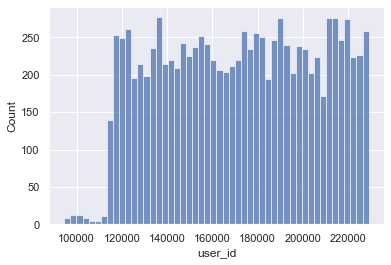

,
mean,171814.71
median,172728.00
std,33708.24
min,94561.00
max,229145.00
1st quantile,114940.71
99th quantile,228019.09



score - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,348,0,0


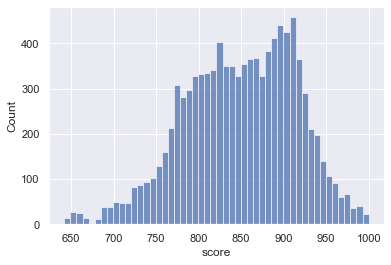

,
mean,848.70
median,853.00
std,65.45
min,642.00
max,1000.00
1st quantile,686.99
99th quantile,978.00



city - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
10000,100.00%,0,0.00%,3,0


,
Most common,
Ярославль,59.1%
Рыбинск,26.6%
Ростов,14.3%



gender - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
10000,100.00%,0,0.00%,2,0


,
Most common,
М,50.1%
Ж,49.9%



age - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,68,0,0


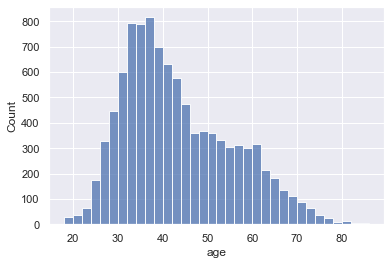

,
mean,42.84
median,40.00
std,12.13
min,18.00
max,86.00
1st quantile,23.00
99th quantile,73.00



balance - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
7705,77.05%,2295,22.95%,7701,2,0


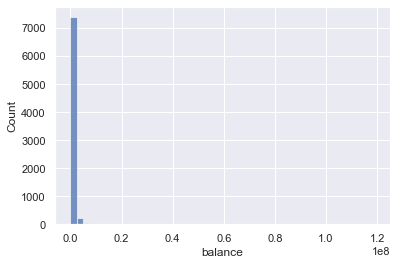

,
mean,827794.31
median,524272.20
std,1980614.15
min,0.00
max,119113552.01
1st quantile,23267.42
99th quantile,4827443.49



products - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,6,1,0


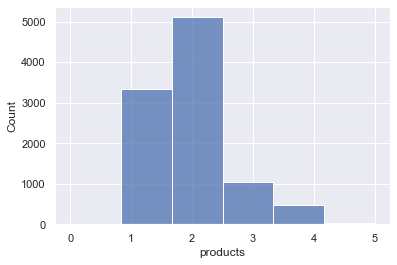

,
mean,1.87
median,2.00
std,0.80
min,0.00
max,5.00
1st quantile,1.00
99th quantile,4.00



has_credit_card - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,2,3196,0


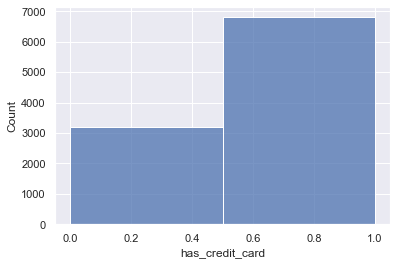

,
mean,0.68
median,1.00
std,0.47
min,0.00
max,1.00
1st quantile,0.00
99th quantile,1.00



is_active - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,2,4765,0


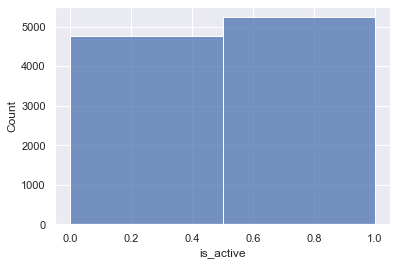

,
mean,0.52
median,1.00
std,0.50
min,0.00
max,1.00
1st quantile,0.00
99th quantile,1.00



salary - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,9996,0,0


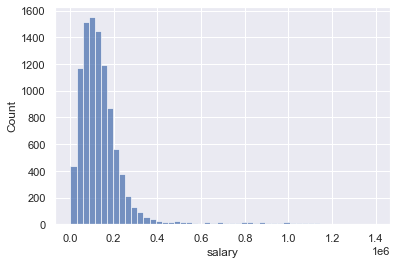

,
mean,147866.89
median,119658.10
std,139388.51
min,2546.30
max,1395064.45
1st quantile,17349.04
99th quantile,887903.85



churn - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
10000,100.00%,0,0.00%,2,8178,0


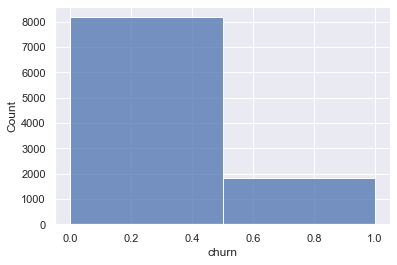

,
mean,0.18
median,0.00
std,0.39
min,0.00
max,1.00
1st quantile,0.00
99th quantile,1.00



EDA brief

Rows in dataset: 10000
Columns in dataset: 11
Number of columns with missing values: 1
Columns with missing values:  ['balance']

Duplicates in dataset: 


,duples_cnt,duples_pct,case_sensitive_duples,case_sensitive_pct,id_duples,id_duples_pct
0,1,0.01%,0,0.00%,73,0.73%


In [7]:
df_eda(df)

In [8]:
def drop_duples(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].str.replace('ё','е')
      if (df[col].str.lower().duplicated().sum() - df[col].duplicated().sum()) > 0:
        df[col] = df[col].str.lower()
  df = df.drop_duplicates()
  return df

In [27]:
df = drop_duples(df)

После удаления одного полного дубликата у нас осталось еще 72 дубликата по колонке user_id. Предполагается, что в датасете должны быть записи только об уникальных клиентах, дубликаты могут быть результатом технической ошибки либо повторных записей для одного и того же клиента. Удалим их с сохранением самых недавних записей.

In [28]:
df = df.drop_duplicates(subset=['user_id'], keep='last')

Формат данных во всех столбцах проставлен корректно, изменений не требуется.

Каких-то явных аномалий не просматривается. Отрицательных и неадекватных значений нигде не присутствует. 

Целевой переменной для нашего исследования является столбец churn - индикатор ушедших/неушедших клиентов. Доля ушедших клиентов составляет 18%. 

Пропуски присутствуют в единственном столбце - balance. Всего пропущенных значений 23% - это значительный объем. Посмотрим на матрице корреляций, есть ли у столбца balance сильные корреляции с другими признаками, чтобы мы могли предложить корректную замену пропусков.

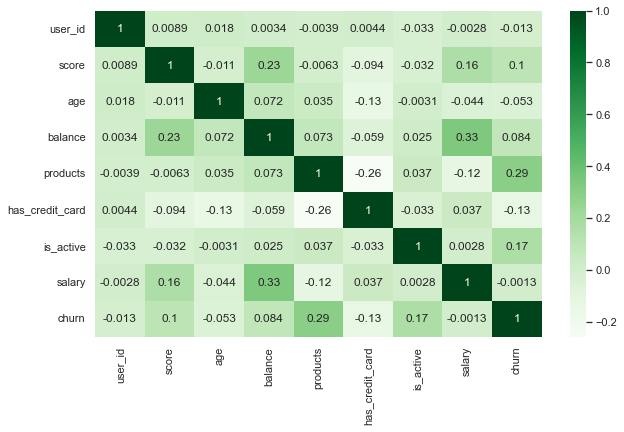

In [29]:
ax, fig = plt.subplots(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.show();

Максимальный коэффициент корреляции у столбца balance присутствует со столбцом salary, однако коэффициент (0.33) в этом случае не достаточно высокий, чтобы можно было говорить о наличии серьезной линейной корреляции. Остальные связи еще более слабые, поэтому оставим пропущенные значения без замены. На этапе сегментации клиентов мы будет использовать алгоритм CatBoostClassifier , который хорошо работает и при наличии пропусков в вещественных переменных.

In [30]:
df.products.value_counts(normalize=True)

2    0.511736
1    0.334643
3    0.104664
4    0.046036
5    0.002821
0    0.000101
Name: products, dtype: float64

Более половины клиентов банка - это жители Ярославля (59%). Чуть более четверти - из Ярославля (27%) и меньше всего - из Ростова (14%). Мужчины и женщины примерно поровну делятся среди клиентов банка (по 50%). Подавляющее число клиентов пользуется одним или двумя банковскими продуктами (51% и 33% соответственно). У 10% есть три продукта, у 5% - четыре продукта, а вот максимальным число - пятью - пользуются единицы (0,3%). Отсутствуют какие-либо продукты банка только у одного клиента. Удалим его как аномалию.

In [31]:
df = df.query('products != 0')

Чуть более двух третей клиентов имеют кредитные карты в банке (68%). Число клиентов без кредитных карт составляет 32%, т.е. почти треть данным банковским продуктом по каким-то причинам не пользуется. 

Среднее число объектов в собственности - 2,6. При этом у четверти клиентов нет вообще каких-либо объектов. У остальных в собственности, в основном, от двух до пяти объектов. Более этого кол-ва имеется в наличии лишь у 3% клиентов.

По показателю last_activity больше группа активных (52%).

В столбце score (баллы кредитного скоринга) присутствуют значения от 642 до 1000. Распределение данных близко к нормальному с небольшим смещением вправо - клиенты чаще получают баллы выше среднего, поэтому медианное значение (853) несколько выше среднего (849). 

Возрастные рамки клиентов банка - от 18 до 86 лет. Средний возраст - 43 года, медианный - 40 лет, т.е. присутствует определенное смещение в сторону более молодых клиентов, что хорошо видно на гистограмме распределения. 

In [32]:
df.query('balance > 4800000').balance.sum()/df.balance.sum()

0.13998540291645256

Распределение данных в столбце balance сильно смещено влево. Основная доля клиентов имеет баланс на счетах от 23 тыс. до 4,8 млн руб. При этом встречаются большие выбросы - до 119 млн руб., хотя таких состоятельных клиентов - очень мало (менее 1%).  
Нулевой баланс только у двух клиентов.

Избавляться от выбросов в нашем случае нецелесообразно, поскольку клиенты с большим балансом на счетах, несмотря на их немногочисленность, имеют большое значение для банка (при том, что они составляют всего 1% всех клиентов, объем денежных средств на их счетах составляет 14%), поэтому их необходимо включить в дальнейшее исследование, чтобы проанализировать склонность к уходу и в этой группе тоже.

Распределение зарплат также сильно смещено влево и близко к логнормальному. Минимальные показатели зарплаты - 2500 руб., что выглядит странным. Можно предположить, что низкие зарплаты проставляются у клиентов, не имеющих в момент сбора данных работы и получающих какие-либо пособия. Либо данный показатель может представлять собой среднюю оценку зарплаты за определенный период, поэтому у клиентов с большим периодом простоя без работы средние показатели могут быть такими низкими.

Максимальная зарплата - 1 млн 395 тыс., однако настолько благополучных клиентов немного. У подавляющей части зарплата колеблется в пределах от 17 тыс. до 880  тыс. 

Вопрос об удалении выбросов (клиенты с большими зарплатами) опять-таки рассматривать нецелесообразно по тем же причинам, что и в случае с клиентами, имеющими большой баланс. Поэтому данных клиентов оставляем в датасете для дальнейшего анализа.

### **Итоги исследовательского анализа. Портрет среднестатистического клиента банка**

+ Более половины клиентов банка - это жители Ярославля (59%). Чуть более четверти - из Ярославля (27%) и меньше всего - из Ростова (14%).
+ Возрастные рамки клиентов банка - от 18 до 86 лет. Средний возраст - 43 года, медианный - 40 лет, т.е. присутствует определенное смещение в сторону более молодых клиентов. 
+ Женщины и мужчины делятся примерно поровну. 
+ Подавляющее число клиентов пользуется одним или двумя банковскими продуктами (51% и 33% соответственно). Среднее число продуктов у клиентов банка - 1,9.
+ Чуть более двух третей клиентов имеют кредитные карты в банке (68%). Доля клиентов без кредитных карт составляет 32%.
+ Число ушедших клиентов составляет 18%.
+ Основная доля клиентов имеет баланс на счетах от 22 тыс. до 4 млн руб. Доля клиентов, у которых баланс превышает 4 млн, составляет всего 1%. При этом в общем балансе средств на счетах клиентов их доля составляет 14%. Поэтому было принято решение не избавляться от аномально высоких «выбросов» в колонке balance, а также в колонке estimated_salary.  

### **Портрет клиентов, которые склонны уходить из банка**

Построим матрицу корреляций с использованием коэффициента phik и посмотрим, с какими данными коррелирует столбец churn. Метод phik используем, посколку он способен выявить как линейные, так и нелинейные корреляции.

In [33]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [34]:
import phik

In [35]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['user_id', 'score', 'age', 'balance', 'products', 'has_credit_card', 'is_active', 'salary', 'churn']


In [36]:
t = phik_overview['churn'].sort_values(ascending=False)[1:].reset_index()

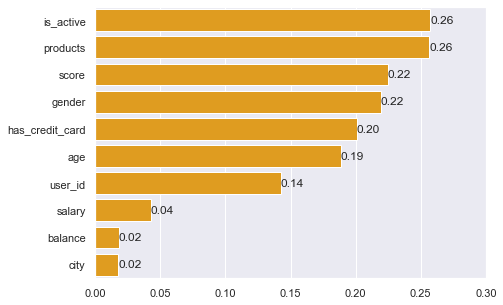

In [38]:
ax, fig = plt.subplots(figsize=(7,5))
ax = sns.barplot(x=t['churn'], y=t['index'], color='orange')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.xlabel('')
plt.ylabel('')
plt.xlim(0,0.3)
plt.show();

Коэффициент корреляций phik показывает небольшую связь между столбцом churn и столбцами is_active, products, а также столбцами score, gender, has_credit_card и age. Связь оттока с балансом и с городом по матрице phik фиксируется практически нулевая. 

Посмотрим, отличаются ли по средним показателям объема баллов, зарплаты, баланса и другим характеристикам клиенты, ушедшие из банка, от среднестатическых клиентов, а также от лояльных клиентов, т.е. тех, которые остаются. Объединим данные в одну переменную и выведем итоговую таблицу.

In [39]:
mean_all = (
    df[['score', 'age', 'balance', 'products', 'salary', \
        'has_credit_card', 'is_active']]
 .apply(['mean']).rename(index={'mean': 'среднее для всех клиентов'})
)

mean_loyal = (
    df.query('churn == 0')[['score', 'age', 'balance', 'products',\
                            'salary', 'has_credit_card', 'is_active']]
             .apply(['mean']).rename(index={'mean': 'среднее для лояльных'})
)

mean_left = (
    df.query('churn == 1')[['score', 'age', 'balance', 'products',\
                            'salary', 'has_credit_card', 'is_active']]
             .apply(['mean']).rename(index={'mean': 'среднее для ушедших'})
)

mean_joined = pd.concat([mean_all, mean_loyal, mean_left])

(
    mean_joined.rename(columns={'score':'баллы', 'age':'возраст', \
                  'balance':'баланс', 'products':'продукты', \
                  'salary':'зарплата', 'has_credit_card':'кредитка', \
                  'is_active':'активность'})
    .style.background_gradient(cmap='BuGn', axis=0, low=0.2, high=1)
    .format('{:.2f}').format('{:.1%}', subset=['кредитка', 'активность'])
)

,баллы,возраст,баланс,продукты,зарплата,кредитка,активность
среднее для всех клиентов,848.46,42.87,822770.80,1.87,147561.87,68.1%,52.2%
среднее для лояльных,845.31,43.17,731855.00,1.76,147633.10,70.9%,48.3%
среднее для ушедших,862.94,41.47,1127271.49,2.37,147233.64,55.1%,70.0%


Средний возраст клиентов, склонных к оттоку - 41,5 год (ниже, чем средний возраст клиентов банка в целом и лояльных клиентов - 43 года). Средняя зарплата у уходящих клиентов - ок. 147,2 тыс. руб. (примерно как и в среднем по банку и у лояльных клиентов - 147,6 тыс. и 147,6 тыс., т.е. разница есть, но незначительная). Средний баланс на счетах - 1,1 млн (заметно выше, чем в среднем по банку - 822 тыс. и у лояльных клиентов - 732 тыс.) 

Средний балл кредитного скоринга - 863: тоже выше, чем в целом по банку (849) и у лояльных клиентов (845). Число банковских продуктов, которыми пользовались ушедшие, также заметно выше, чем в целом по банку и у лояльных клиентов (2,4 против 1,9-1,8 соответственно).

Доля клиентов с кредитными картами среди ушедших, напротив, меньше (55% против 71% у лояльных). А вот показатели активности у уходящих больше (70% против 48% у лояльных). 

Таким образом, заметные отличия наблюдаются по показателю баланса средств на счетах, кол-ву банковских продуктов, наличию кредитных карт и активности. Менее выражены различия в средней заработной плате, баллах кредитного скоринга, возрасте - статистическую значимость этих различий надо проверять.  

Теперь посмотрим, как распределяются уходящие клиенты по таким категориальным признакам, как город и пол.

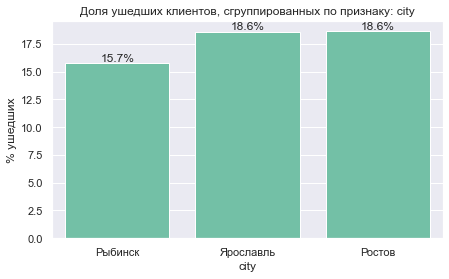

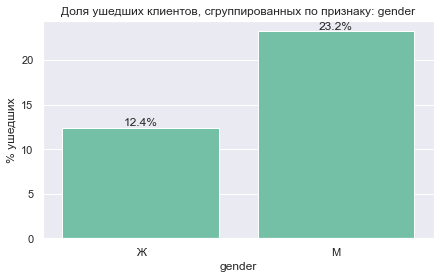

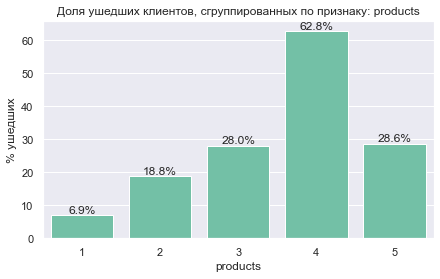

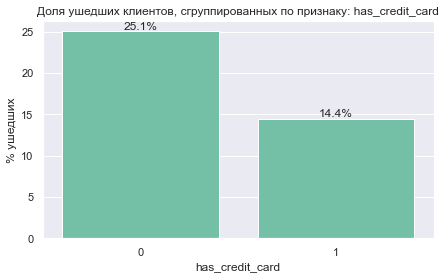

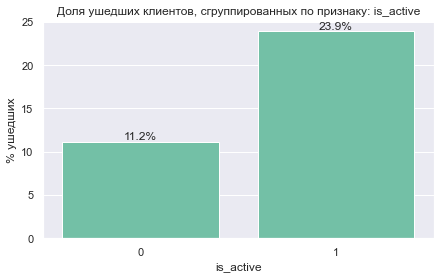

In [41]:
for col in ['city', 'gender', 'products', 
            'has_credit_card', 'is_active']:
    fig, ax = plt.subplots(figsize=(7,4))
    ax = sns.barplot(x=df[col], y=df.churn*100, ci=False, color='mediumaquamarine')
    ax.set_title(f'Доля ушедших клиентов, сгруппированных по признаку: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel("% ушедших")
    ax.bar_label(ax.containers[0], fmt='%.1f%%')
    plt.show();

Мы видим, что процент оттока клиентов в Ростове и Ярославле несколько больше, чем в Рыбинске (19% против 16%). Гипотезу о наличии/отсутствии статистической значимости в соотношениях ушедших в Рыбинске и других городах целесообразно проверить  на след.этапе.

Доля ушедших из банка мужчин на 11% больше, чем доля ушедших женщин. Сильный пол, судя по всему, больше склонен к переменам в этом плане, в то время как прекрасный пол демонстрирует больший консерватизм. В итоге доля мужчин среди ушедших клиентов составлет 65% (почти две трети), хотя среди всех клиентов банка женщины и мужчины делятся поровну. 

Клиенты без кредитной карты в процентном отношении склонны уходить чаще, чем клиенты с кредитной картой (отток в первой группе 26% против 15% во второй группе). 

Реже всего из банка уходят клиенты, у которых имеется один банковский продукт, чаще всего - с четырьмя продуктами, причем доля последних значительно отличается от остальных групп (63% против 29% у клиентов с тремя продуктами и 30% с пятью). Если не брать во внимание группу клиентов с пятью продуктами (она немногочисленна - всего 0,3% от всех клиентов), то можно говорить о явной тенденции - тем большим кол-вом банковских продуктов пользуется клиент, тем он больше склонен к тому, чтобы поменять  банк.

In [42]:
df['score_groups'] = (
    pd.cut(df.score, bins=[640, 750, 775, 800, 825, 850, 875, 900, 925, 950, 1000], 
           labels=['640-750', '751-775', '776-800', '801-825', '826-850', '851-875', \
                   '876-900', '901-925', '926-950', '951-1000'], 
           include_lowest=True)
)

In [43]:
df['balance_groups'] = (
    pd.cut(df.balance, bins=[0, 100000, 200000, 300000, 400000, 500000, 600000, 800000, 1100000, 1500000, 120000000],
           labels=['0-100', '101-200', '201-300', '301-400', '401-500', '501-600',\
                   '601-800', '801-1100', '1101-1500', '1501-120000'], include_lowest=True)
)

In [44]:
df['age_groups'] = (
    pd.cut(df.age, bins=[18, 30, 35, 40, 45, 50, 55, 60, 65, 86], 
           include_lowest=True, labels=['18-30', '31-35', \
                                        '36-40', '41-45', '46-50', '51-55', \
                                        '56-60', '61-65', '66-86'])
)

In [45]:
df['salary_groups'] = (
    pd.cut(df.salary, 
           bins=[0, 50000, 100000, 150000, 200000, \
                 250000, 1400000], 
           labels=['0-50', '51-100', '101-150', '151-200', \
                   '201-250', '251-1400'])
)

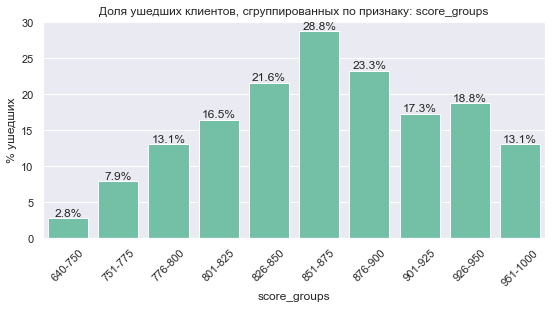

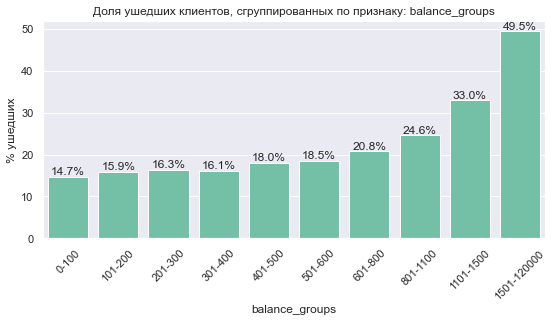

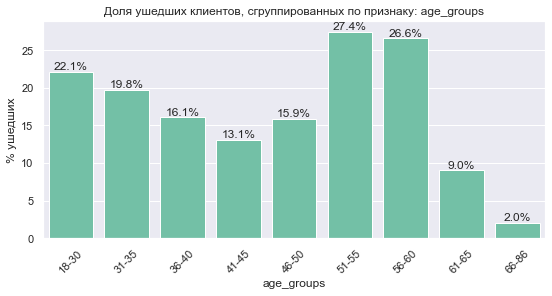

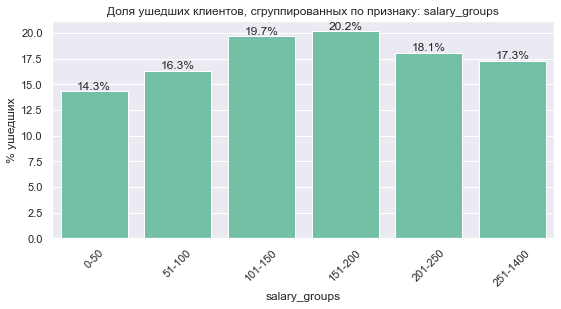

In [46]:
for col in ['score_groups', 'balance_groups', 
            'age_groups', 'salary_groups']:
    fig, ax = plt.subplots(figsize=(9,4))
    ax = sns.barplot(x=df[col], y=df.churn*100, ci=False, color='mediumaquamarine')
    ax.set_title(f'Доля ушедших клиентов, сгруппированных по признаку: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel("% ушедших")
    ax.bar_label(ax.containers[0], fmt='%.1f%%')
    plt.xticks(rotation=45)
    plt.show();

In [47]:
# Напишим функцию для визуализации изменения доли ушедших клиентов в зависимости от возраста, зарплаты, баллов и баланса
def vis_links(feature, subtitle):
  # определим столбцы, данных из которых мы будем откладывать по оси x
  groups = [['age_groups', 'salary_groups'], ['score_groups', 'balance_groups']]
  data_dict = {'age_groups':'возраст', 'salary_groups':'зарплата, тыс.руб.', \
               'score_groups':'баллы', 'balance_groups':'баланс, тыс.руб.'}
  colors = sns.color_palette('Set2', len(df[feature].unique()))

  fig, ax = plt.subplots(2, 2, figsize=(18,8))
  # Напишем цикл для визуализации данных по каждой выбранной категории
  for i in range(2):
    for j in range(2):
      data=df[~df[groups[i][j]].isna()]  
      if feature == 'gender':
        hue_order = ['М', 'Ж']
        sns.lineplot(x=groups[i][j], y='churn', hue=feature, data=data, ci=False, palette=colors, \
                     hue_order=hue_order, linewidth=3, ax=ax[i,j])
      else:
        sns.lineplot(x=groups[i][j], y='churn', hue=feature, data=data, ci=False, palette=colors, linewidth=3, ax=ax[i,j])
      
      ax[i,j].set_ylim(0,1)
      ax[i,j].set_ylabel('')
      ax[i,j].legend()
      ax[i,j].set_xlabel(data_dict[groups[i][j]])
      vals = ax[i,j].get_yticks()
      ax[i,j].set_yticklabels(['{:.0%}'.format(val) for val in vals])
      if i == 1:
        for label in ax[i,j].get_xticklabels():
          label.set_rotation(45)

  plt.suptitle(subtitle)
  plt.show();

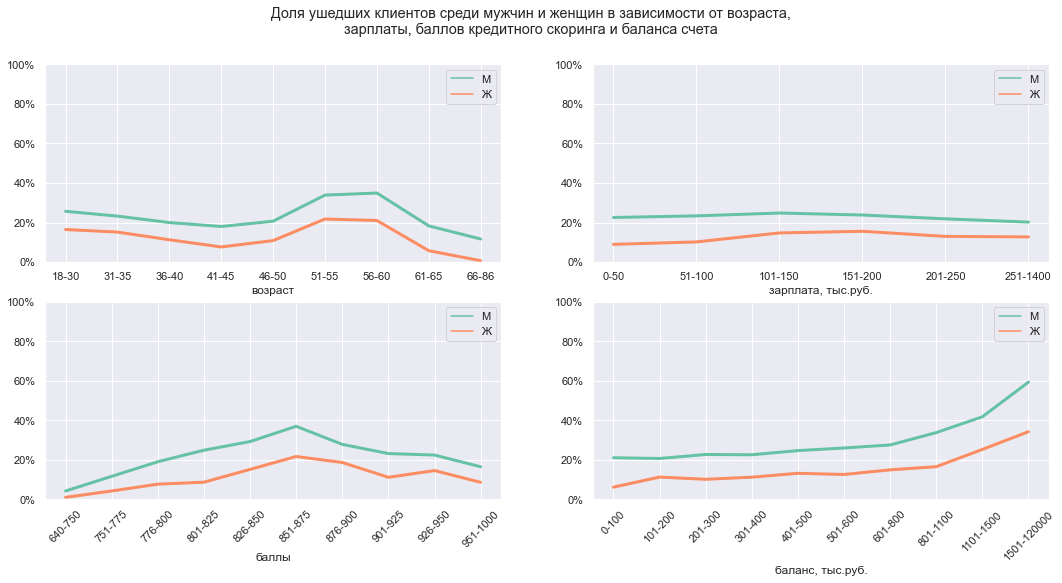

In [48]:
subtitle = 'Доля ушедших клиентов среди мужчин и женщин в зависимости от возраста,\nзарплаты, баллов кредитного скоринга и баланса счета'
vis_links('gender', subtitle)

Почти везде графики доли ушедших среди мужчин и женщин идут параллельно (при этом везде отток среди мужчин больше). Отток выше среднего фиксируется в возрастных группах от 50 до 60 лет (более 35% у мужчин, более 20% у женщин) и  среди молодых мужчин в возрасте до 30 лет (более 25%).  

Кроме того, видна тенденция к росту доли ушедших среди мужчин и женщин с высокими показателями баланса средств на счетах. У мужчин с балансом более 1,5 млн. руб. отток достигает 60% и более 35% у женщин. В группе с балансом более 1,1 млн показатели оттока также выше среднего (более 40% у мужчин и более 25% у женщин). Т.е. опять-таки мы наблюдаем отток самых состоятельных клиентов.  

В зарплатных группах доля ушедших клиентов примерно одинакова и колеблется в пределах от 10 до 18% у женщин и чуть более 20% у мужчин. Таким образом, ни одна из групп не демонстрирует повышенной склонности к переходу в другие банки. Уходящие клиенты равномерно распределены в зависимости от своего дохода. Однако эта гипотеза требует дополнительной проверки с использованием статистической оценки.

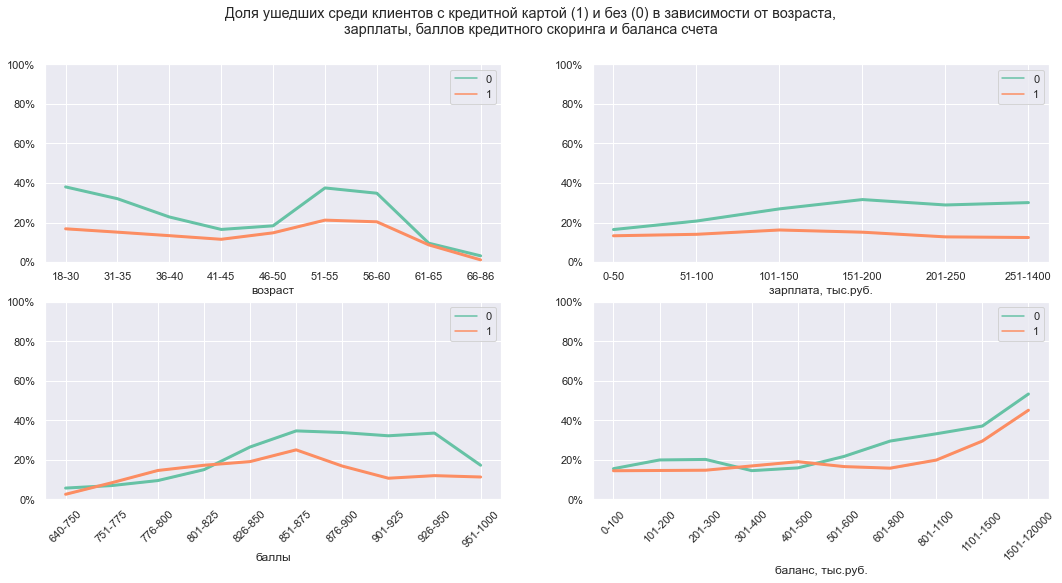

In [49]:
subtitle = 'Доля ушедших среди клиентов с кредитной картой (1) и без (0) в зависимости от возраста,\nзарплаты, баллов кредитного скоринга и баланса счета'
vis_links('has_credit_card', subtitle)

Клиенты без кредитной картой чаще склонны менять банк. Особенно заметна разница в доле ушедших среди клиентов в возрастных группах до 30 лет и от 50 до 60 лет, с хорошими зарплатами (от 150 тыс. и выше), а также с баллом кредитного скоринга выше среднего (850 баллов и выше). У таких клиентов процент оттока достигает 40% либо приближается к этой цифре на фоне среднего показателя оттока в 18%. 

Следует также отметить, что среди клиентов с высоким балансом повышенная склонность к уходе наблюдается как у тех, кто не имеет кредитной карты, так и те, кто имеет (ок. 55% и 45% соответственно).

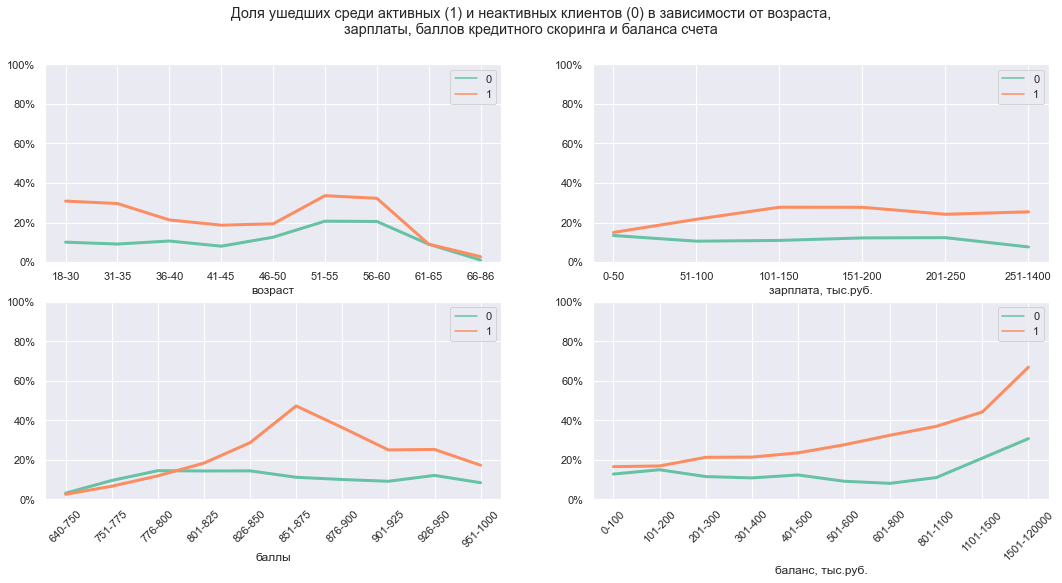

In [50]:
subtitle = 'Доля ушедших среди активных (1) и неактивных клиентов (0) в зависимости от возраста,\nзарплаты, баллов кредитного скоринга и баланса счета'
vis_links('is_active', subtitle)

Активность клиента также чаще влечет за собой смену банка. Уходящие в возрастных группах до 30 лет и от 50 до 60 лет - это как раз активные клиенты. Средний балл у таких клиентов, как правило в районе 850-875. 

В группах с высоким балансом тоже чаще уходят именно активные клиенты (более 60% против 30% среди неактивных).

Отток в группе клиентов с высоким балансом на счетах заставляет задуматься о недостаточной привлекательности имеющихся у банка продуктов для удержания обеспеченных клиентов (программ привилегий и пр.)

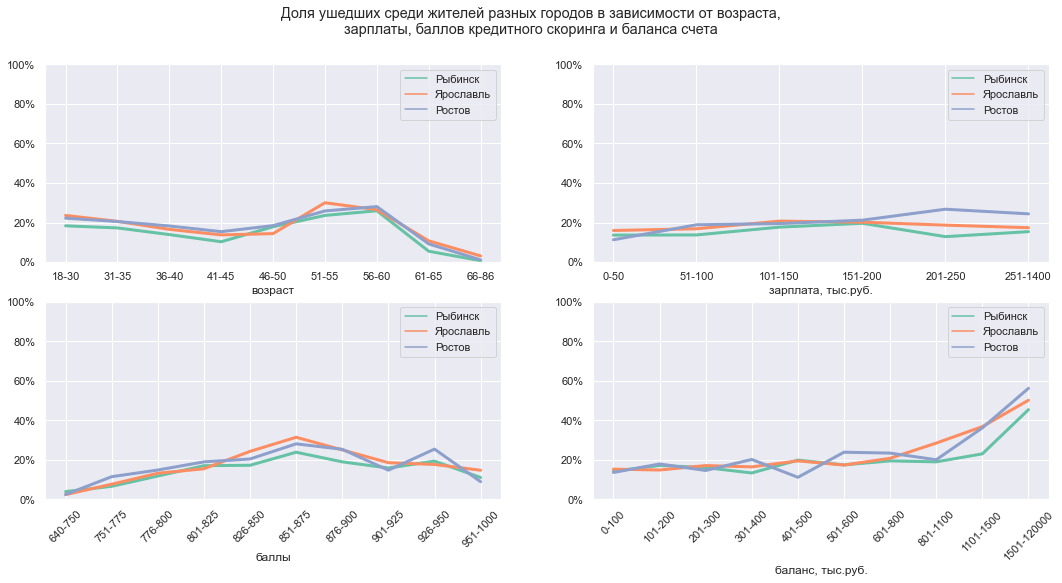

In [51]:
subtitle = 'Доля ушедших среди жителей разных городов в зависимости от возраста,\nзарплаты, баллов кредитного скоринга и баланса счета'

vis_links('city', subtitle)

Мы видим, что поведенческие паттерны среди жители трех городов довольно схожи. И хотя у жителей Ростова и Ярославля несколько больше процент оттока, в общем и целом, графики по всех группах практически идентичны. По доли ушедших немного обгоняют других клиентов ростовчане с высокими зарплатами (более 200 тыс. и балансом на счетах более 1,5 млн.). Однако нужно подчеркнуть, что в последней группе высокий отток наблюдается и в других городах.

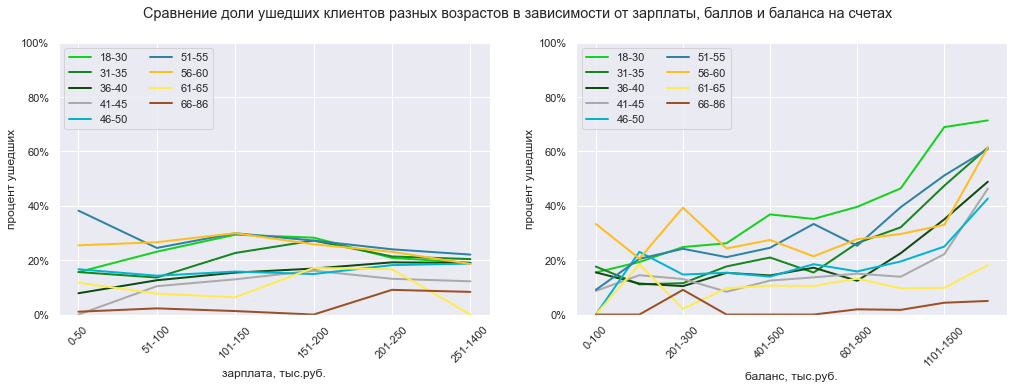

In [52]:
# Визуализируем распределение оттока в зарплатных и балансовых группах в зависимости от возраста
age_groups = sorted(df.age_groups.unique())
t = ['salary_groups', 'balance_groups']
data = {'salary_groups':'зарплата, тыс.руб.', 'score_groups':'баллы', 'balance_groups':'баланс, тыс.руб.'}
colors= ['#14D21E', '#14871E', '#0F4B0F', '#AAAAAA', '#00B4D2', '#2D82A5','#FFBE1E', '#FFEB50', '#9B5028']

fig, ax = plt.subplots(1, 2, figsize=(17,5))

for i in range(2):
  for j, value in enumerate(age_groups):
    df.query('age_groups == @value').groupby(t[i])['churn'].agg('mean').plot(ylim=(0,1), color=colors[j], lw=2, ax=ax[i])
    ax[i].set_ylabel('процент ушедших')
    ax[i].legend(age_groups, loc='upper left', ncol=2)
    ax[i].set_xlabel(data[t[i]])
    for label in ax[i].get_xticklabels():
      label.set_rotation(45)
    vals = ax[i].get_yticks()
    ax[i].set_yticklabels(['{:.0%}'.format(val) for val in vals])

plt.suptitle('Сравнение доли ушедших клиентов разных возрастов в зависимости от зарплаты, баллов и баланса на счетах')
plt.show();

Среди возрастных групп наибольший отток практически во всех группах наблюдается в возрасте от 50 до 60 лет, т.е. можно сказать, что склонность к переменам совпадает с классическим периодом "кризиса среднего возраста". Кроме того, мы видим ярко выраженную тенденцю к росту оттока среди молодых клиентов в возрасте до 35 лет по мере увеличения баланса средств на счетах: при балансе, достигающем 600 тыс., этот показатель начинает превышать 40%, а у молодых клиентов с балансом более 1,1 млн руб. достигает 60%-70%. 

### **Сегментация ушедших клиентов**

Создадим ML-модель на основе алгоритма CatBoostClassifier и проставим скоры с оценкой вероятности оттока для всех клиентов по имеющимся признакам. Затем разделим клиентов на сегменты в зависимости от степени их склонности к уходу из банка и изучим особенности каждой из групп. 

In [53]:
! pip install catboost

In [54]:
from catboost import CatBoostClassifier
from catboost import Pool

In [55]:
train, test = train_test_split(df, train_size=0.6, random_state=42, stratify=df['churn'])
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['churn'])

In [56]:
train.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'balance', 'products',
       'has_credit_card', 'is_active', 'salary', 'churn', 'score_groups',
       'balance_groups', 'age_groups', 'salary_groups'],
      dtype='object')

In [57]:
X = ['score', 'city', 'gender', 'age', 'balance',
       'products', 'has_credit_card', 'is_active', 'salary']

cat_features = ['city', 'gender']
y = ['churn']

In [58]:
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [59]:
params = {'verbose':100,
          'eval_metric':'AUC',
          'random_seed':42,
          'learning_rate':0.012
          }

In [60]:
model = CatBoostClassifier(**params)

In [61]:
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6641553	best: 0.6641553 (0)	total: 163ms	remaining: 2m 43s
100:	test: 0.8724215	best: 0.8724215 (100)	total: 2.75s	remaining: 24.5s
200:	test: 0.8823224	best: 0.8823224 (200)	total: 4.8s	remaining: 19.1s
300:	test: 0.8865172	best: 0.8865311 (298)	total: 6.96s	remaining: 16.2s
400:	test: 0.8894685	best: 0.8894685 (400)	total: 8.79s	remaining: 13.1s
500:	test: 0.8911433	best: 0.8911433 (500)	total: 10.3s	remaining: 10.2s
600:	test: 0.8927870	best: 0.8928303 (599)	total: 11.8s	remaining: 7.86s
700:	test: 0.8938799	best: 0.8938799 (700)	total: 13.6s	remaining: 5.82s
800:	test: 0.8942072	best: 0.8943562 (784)	total: 15.2s	remaining: 3.78s
900:	test: 0.8943700	best: 0.8943700 (900)	total: 16.8s	remaining: 1.85s
999:	test: 0.8942141	best: 0.8944532 (953)	total: 18.4s	remaining: 0us

bestTest = 0.8944531621
bestIteration = 953

Shrink model to first 954 iterations.


In [62]:
test['catboost_score'] = model.predict_proba(test[X])[:,1]

In [71]:
roc_auc_score(test['churn'], test['catboost_score'])

0.8901489974520882

In [72]:
average_precision_score(test['churn'], test['catboost_score'])

0.7098320338434247

In [73]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,balance,25.479620
1,score,18.738199
2,age,14.826355
3,is_active,12.798068
4,products,7.994830
5,gender,7.530396
6,salary,5.868216
7,city,3.455118
8,has_credit_card,3.309198


In [74]:
df['catboost_score'] = model.predict_proba(df[X])[:,1]

In [75]:
df['score_bins'] = pd.cut(df['catboost_score'], 4, labels=[0, 1, 2, 3])

In [76]:
df.groupby('score_bins')['churn'].agg(['count', 'mean'])

,count,mean
score_bins,,
0,7657,0.054199
1,1151,0.374457
2,580,0.710345
3,538,0.951673


Мы получили поступательное увеличение процента оттока клиентов по мере роста catboost_score, как и было задумано. Из всех групп нас интересуют сегменты с процентом оттока больше среднего, т.е. более 18%. Это группы 1, 2 и 3. На их основе и произведем сегментацию. 

Посмотрим на количественные и качественные характеристики каждого сегмента.

In [77]:
for seg in range(1,4):
    print(f'Сегмент {seg}:')
    print('Кол-во ушедших клиентов в сегменте: ', len(df[df['score_bins'] == seg].query('churn == 1')))
    print('Доля отточных в сегменте: ', round(df[df['score_bins'] == seg].churn.mean()*100, 1), '%')
    print('')

Сегмент 1:
Кол-во ушедших клиентов в сегменте:  431
Доля отточных в сегменте:  37.4 %

Сегмент 2:
Кол-во ушедших клиентов в сегменте:  412
Доля отточных в сегменте:  71.0 %

Сегмент 3:
Кол-во ушедших клиентов в сегменте:  512
Доля отточных в сегменте:  95.2 %



По числу ушедших клиентов сегменты распределились относительно равномерно с небольшим перевесом в пользу 3-го сегмента с наибольшим оттоком. В первом сегменте отток составил в среднем  37%, т.е. здесь уходит более трети  всех клиентов банка, во втором - 71%, в третьем - 95% (уходит подавляющая часть клиентов). 

Посмотрим на средние показатели всех признаков в выделенных сегментах по сравнению с банком в целом.

In [78]:
df['score_bins'] = df['score_bins'].astype('int')

In [79]:
t = df[['score', 'city', 'gender', 
        'age', 'balance', 'products',         
        'has_credit_card', 'is_active', 
        'salary', 'churn', 'score_bins']]
t = pd.get_dummies(t)

In [80]:
t.head()

,score,age,balance,products,has_credit_card,is_active,salary,churn,score_bins,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,850.0,25,59214.82,2,0,1,75719.14,1,1,0,1,0,1,0
1,861.0,37,850594.33,3,1,0,86621.77,0,0,0,1,0,1,0
2,892.0,30,NaN,1,1,1,107683.34,0,0,0,1,0,1,0
3,866.0,51,1524746.26,2,0,1,174423.53,1,3,0,0,1,1,0
4,730.0,34,174.00,1,1,0,67353.16,1,0,0,0,1,0,1


In [81]:
banks_joined = t.apply('mean').to_frame('bank_total')
seg1 = t.query('score_bins == 1').apply('mean').to_frame('seg1')
seg2 = t.query('score_bins == 2').apply('mean').to_frame('seg2')
seg3 = t.query('score_bins == 3').apply('mean').to_frame('seg3')

banks_joined = banks_joined.join(seg1)
banks_joined = banks_joined.join(seg2)
banks_joined = banks_joined.join(seg3)

In [103]:
banks_joined.style.format('{:.2f}')

,bank_total,seg1,seg2,seg3
score,848.46,848.34,877.62,899.07
age,42.87,42.99,41.03,39.00
balance,822770.80,856112.22,1376245.91,1710094.39
products,1.87,2.29,2.37,2.88
has_credit_card,0.68,0.59,0.50,0.44
is_active,0.52,0.71,0.85,0.85
salary,147561.87,122644.87,159086.63,199773.36
churn,0.18,0.37,0.71,0.95
score_bins,0.40,1.00,2.00,3.00
city_Ростов,0.14,0.15,0.11,0.11


В третий сегмент, где наблюдается наибольший отток (95%), попали наиболее молодые клиенты (средний возраст 39 лет) с большим балансом средств на счетах (более 1,7 млн руб.). Большая часть их них не имеет кредитных карт, при этом, как правило, это максимально активные клиенты. В этой группе также значительно превалируют мужчины (70%) и жители Ярославля (69% против 59% по банку в целом).

Во втором сегменте со средним оттоком (71%) - клиенты также немного моложе, чем в целом по банку (средний возраст 41 год). Это тоже довольно обеспеченные клиенты с большими средствами на счетах, однако уступающие третьему сегменту по сумме баланса (1,4 млн в среднем). В процентном соотношении здесь больше женщин, чем в первом сегменте, хотя мужчины по-прежнему преобладают (63%). Во второй сегмент также попали преимущественно активные клиенты (85% активных). 

Первый сегмент, где отток среди ушедших самый низкий, но все же превышает средние показатели по банку в целом (37%), самый "возрастной" из всех трех сегментов - средний возраст 43 года - даже выше, чем по банку в целом. Сюда попали клиенты с меньшим "достатком": средний баланс средств на счетах - 856 тыс. (чуть больше, чем в среднем по банку). Это менее активные клиенты, чем в других сегментах (активность 71%) и в отличие от остальных групп, они, по большей части, имеют кредитные карты. Мужчины опять-таки преобладают. В процентном соотношении полов этот сегмент практически идентичен второму.

### **Портрет клиента, склонного к уходу. Общие выводы**

Как показал анализ, клиенты-мужчины более склонны к уходу из банка, чем женщины (24% оттока среди мужчин и только 13% среди женщин). Особенно заметна тенденция к смене банка среди молодых мужчин в возрасте до 30 лет и среди мужчин в возрасте от 50 до 60 лет (отток 25% и 35% соответственно на фоне 18% в среднем по банку). 

Кроме того, активно уходят клиенты с высокими показателями баланса средств на счетах (как мужчины, так и женщины: у мужчин с балансом более 1,5 млн. руб. отток достигает 60%, у женщин - более 35%). 

В целом, можно говорить о том, из банка склонны уходить более благополучные в денежном плане клиенты. У уходящих клиентов выше средний доход, чем у лояльных клиентов (148,2 тыс. руб. против 147,8 тыс.), выше средний баланс на счетах (1 млн 133 тыс. против 734 тыс. у лояльных клиентов), выше средний балл кредитного скоринга (863 против 845 у лояльных клиентов) и они пользуются большим числом банковских продуктов (2,4 против 1,8 у лояльных).

Активность клиента также чаще влечет за собой смену банка. Уходящие в возрастных группах до 30 лет и от 50 до 60 лет и с высоким балансом на счетах - это как раз, в основном, активные клиенты.

Что касается жителей разных городов, их поведенческие паттерны относительно смены банка довольно схожи. Хотя у жителей Ростова и Ярославля несколько больше процент оттока (19% против 16% в Рыбинске).

Чаще склонны уходить из банка клиенты, не имеющие кредитной карты. Особенно выделяются в этом плане опять-таки возрастные группы до 30 лет и от 50 до 60 лет с хорошими зарплатами (от 150 тыс. и выше), а также с баллом кредитного скоринга выше среднего (850 баллов и выше): здесь процент оттока достигает 40% либо приближается к этой цифре. 

По результатам исследования можно выделить несколько наиболее «рискованных» с точки зрения оттока категорий клиентов. Процент ухода в этих категориях превышает 50%. Это клиенты, пользующиеся четырьмя банковскими продуктами (отток 63%), клиенты с большим балансом средств на счетах, в первую очередь активные клиенты мужского пола в возрастных группах до 35 и от 50 до 60 лет (отток более 60%). 

**Сегментация отточных клиентов**

Среди ушедших клиентов было выделено три группы, которые различаются по уровню оттока. В сегмент, где наблюдается наибольший отток (95%), попали наиболее молодые клиенты (средний возраст 39 лет) с большим балансом средств на счетах (более 1,7 млн руб.), не имеющие, как правило, кредитных карт, но при этом максимально активные. В этой группе также значительно превалируют мужчины и жители Ярославля.

Во втором сегменте со средним оттоком 71% - также молодые клиенты (средний возраст 41 год), уступающие первому сегменту по сумме баланса (1,4 млн в среднем). В процентном соотношении здесь больше женщин, чем в первом сегменте, хотя мужчины по-прежнему преобладают (63%).  

Последний сегмент, где показатель оттока составляет 37% - самый "возрастной" из всех трех сегментов (средний возраст 43 года. Сюда попали клиенты с меньшим "достатком". Это менее активные клиенты, чем в других сегментах (активность 71%) и в отличие от остальных групп, они, по большей части, имеют кредитные карты. Мужчины опять-таки преобладают. 

## **Проверка статистических гипотез**

In [82]:
# Разделим на две переменных данные по лояльным клиентам (group1) и по ушедшим (group2)
group1 = df.query('churn == 0')
group2 = df.query('churn == 1')

### **Гипотеза 1**

Проверим гипотезу о различии среднего дохода между теми клиентами, которые ушли и теми, которые остались.

In [83]:
# Выведем значения среднего дохода в обеих группах
print('Среднее значение зарплаты в группе лояльных клиентов:', round(group1.salary.mean(), 1))
print('Среднее значение зарплаты в группе нелояльных клиентов:', round(group2.salary.mean(), 1))

Среднее значение зарплаты в группе лояльных клиентов: 147633.1
Среднее значение зарплаты в группе нелояльных клиентов: 147233.6


На первый взгляд разница в средних зарплатах между группами незначительная (всего 400 руб. разницы).

Сформулируем нулевую и альтернативную гипотезу. Пороговое значение альфа установим на уровне 0.05.

H0: Средняя зарплата в группе лояльных клиентов и в группе ушедших одинакова

H1: Средняя зарплата в группах отличается

Для того, чтобы определиться с тем, какой статистический тест мы будем использовать для проверки гипотезы (t-критерий либо критерий Манна-Уитни), проверим данные на нормальность распределения выборочных средних. В случае, если выборочные средние распределены нормально, используем для проверки t-тест, в противном случае - критерий Манна-Уитни.

In [84]:
# Напишем фунцию для проверки данных на нормальность распределения выборочных средних 
def norm_check(col):
  '''Используя метод bootstrap, создадим 100 случайных выборок из данных 
  первой и второй группы и сохраним в переменные t1 и t2 средние 
  этих выборок'''
  t1 = pd.Series([group1[col].sample(frac=1, replace=True).mean() for _ in range(1000)])
  t2 = pd.Series([group2[col].sample(frac=1, replace=True).mean() for _ in range(1000)])

  # Построим гистограммы распределения выборочных средних для группы 1 и группы 2
  fig, ax = plt.subplots(figsize=(10,4))

  t1.hist(bins=30, color='green', alpha=0.5)
  t2.hist(bins=30, color='orange', alpha=0.5)

  plt.show();

  # Проверим нормальность распределения при помощи графика квантиль-квантиль плот
  st.probplot(t1, dist='norm', plot=pylab)
  pylab.show();
  st.probplot(t2, dist='norm', plot=pylab)
  pylab.show();

Проверим данные в столбцах с зарплатой на нормальность распределения выборочных средних

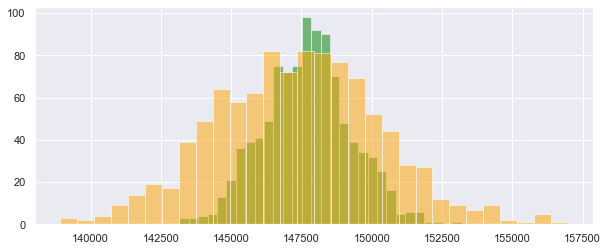

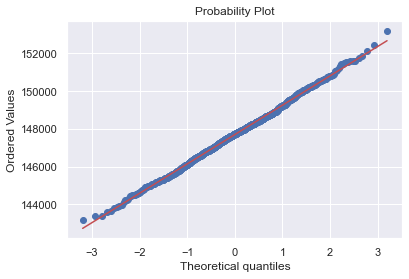

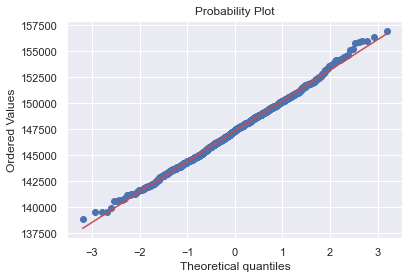

In [85]:
norm_check('salary')

Данные наших распределений практически соответствуют теоретическим квантилям, поэтому можно говорить об их нормальности. Поэтому для проверки того, является ли разница в средних значениях для наших выборок случайной, применим t-тест с указанием equal_var=False, поскольку выборки у нас разные по размеру. 

In [86]:
# Напишем функцию для проведения т-теста
def ttest_check(col):
  results = st.ttest_ind(group1[col], \
                        group2[col], \
                        equal_var=False)

  alpha = 0.05

  print('p-value:', results.pvalue)

  if results.pvalue < alpha:
      print('Отвергаем нулевую гипотезу')
  else:
      print('Не получилось отвергнуть нулевую гипотезу')

In [87]:
ttest_check('salary')

p-value: 0.9030365830890236
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось, значит, делаем вывод, что средние показатели дохода в обеих группах не отличаются. 

### **Гипотеза 2**

Гипотеза 2: о разнице средних значений баллов средитного скоринга 

In [88]:
# Выведем значения среднего балла кредитного скоринга в обеих группах
print('Среднее значение балла кредитного скоринга в группе лояльных клиентов:', round(group1.score.mean(), 1))
print('Среднее значение балла кредитного скоринга в группе нелояльных клиентов:', round(group2.score.mean(), 1))

Среднее значение балла кредитного скоринга в группе лояльных клиентов: 845.3
Среднее значение балла кредитного скоринга в группе нелояльных клиентов: 862.9


Среднее значение баллов кредитного скоринга в группе ушедших на 18 баллов больше, чем в группе лояльных клиентов. Проверим, могли ли мы получить эту разницу случайно.

Сформулируем нулевую и альтернативную гипотезу. Пороговое значение альфа установим на уровне 0.05.

H0: Средний балл кредитного скоринга в группе лояльных клиентов и в группе ушедших одинакова

H1: Средний балл кредитного скоринга в группах отличается

Проверим данные на нормальность распределение выборочных средних

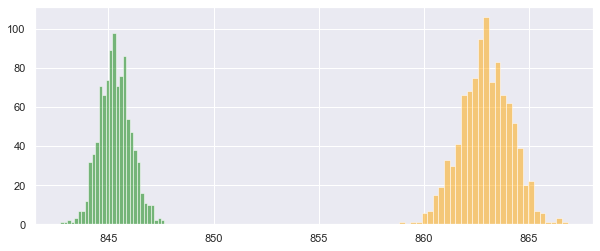

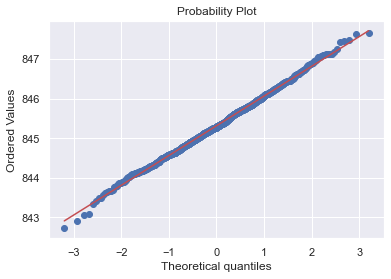

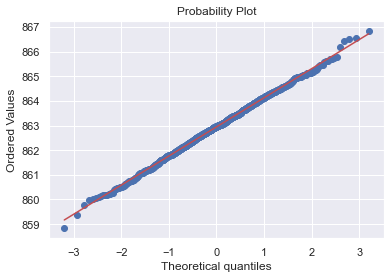

In [89]:
norm_check('score')

По гистограммам распределения выборочных средних видны сильные расхождения между данными первой и второй группы.
Q-q график показывает, что выборочные средние распределены нормально, значит, мы можем использовать для проверки статистической значимости расхождений t-тест.

In [90]:
ttest_check('score')

p-value: 1.4755241087202395e-35
Отвергаем нулевую гипотезу


Значение p-value существенно ниже 0.05. Это значит, что случайно наблюдаемую разницу в средних показателях балла мы получить не могли. Поэтому отвергаем нулевую гипотезу и делаем вывод о статистически значимой разнице по этому показателю между ушедшими клиентами и лояльными.

### **Гипотеза 3**

Гипотеза 3: о разнице в среднем возрасте между ушедшими и оставшимися клиентами

In [91]:
# Выведем значения среднего возраста в обеих группах
print('Средний возраст в группе лояльных клиентов:', round(group1.age.mean(), 1))
print('Средний возраст в группе нелояльных клиентов:', round(group2.age.mean(), 1))

Средний возраст в группе лояльных клиентов: 43.2
Средний возраст в группе нелояльных клиентов: 41.5


Средний возраст в группе ушедших почти на два года ниже, чем в группе лояльных клиентов, т.е. чаще уходят более молодые клиенты. Проверим, могли ли мы получить эту разницу случайно.

Сформулируем нулевую и альтернативную гипотезу. Пороговое значение альфа установим на уровне 0.05.

H0: Средний возраст в группе лояльных клиентов и в группе ушедших одинаковый

H1: Средний возраст в группах отличается

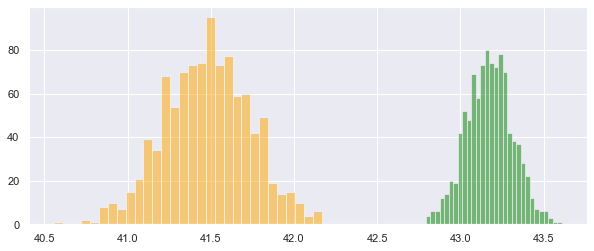

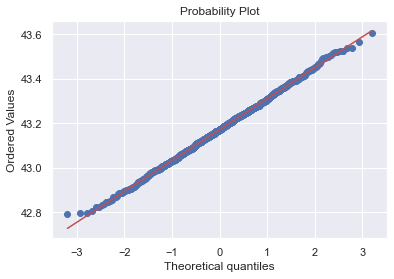

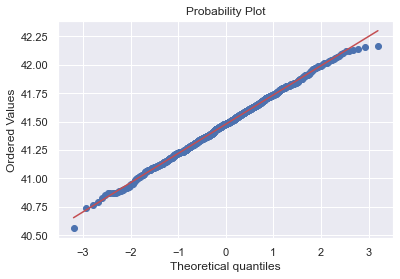

In [92]:
norm_check('age')

По гистограммам распределения выборочных средних мы опять видим сильные расхождения между данными первой и второй группы.
Q-q график показывает, что выборочные средние распределены нормально, значит, мы можем использовать для проверки статистической значимости расхождений t-тест.

In [93]:
ttest_check('age')

p-value: 9.540682861625562e-09
Отвергаем нулевую гипотезу


Значение p-value существенно ниже 0.05. Это значит, что случайно наблюдаемую разницу в средних показателях балла мы получить не могли. 

Отвергаем нулевую гипотезу и делаем вывод о статистически значимой разнице в среднем возрасте между ушедшими клиентами и лояльными.

### **Гипотеза 4**

Гипотеза 4: о разнице в соотношении ушедших и лояльных клиентов среди жителей Ростова, Ярославля и Рыбинска.

In [94]:
# Выведем долю ушедших среди клиентов "Метанпрома" в трех городах
print('Доля ушедших в Ярославле:', round(df.query('city == "Ярославль"').churn.mean(), 2))
print('Доля ушедших в Ростове Великом:', round(df.query('city == "Ростов"').churn.mean(), 2))
print('Доля ушедших в Рыбинске:', round(df.query('city == "Рыбинск"').churn.mean(), 2))

Доля ушедших в Ярославле: 0.19
Доля ушедших в Ростове Великом: 0.19
Доля ушедших в Рыбинске: 0.16


Среди жителей Ярославля и Ростова доля ушедших составляет 19%, а в Рыбинске чуть меньше - 16%. Проверим, насколько стастически значима эта разница с использование z-теста для пропорций с поправкой на множественную проверку гипотез (используем метод Холма-Бонферрони).

Сформулируем нулевую и альтернативную гипотезу. Пороговое значение альфа установим на уровне 0.05.

H0: Доля ушедших клиентов в Рыбинске не отличается от доли ушедших в Ростове и Ярославле

H1: Доля ушедших клиентов в Рыбинске отличается от доли ушедших в Ростове и Ярославле

In [95]:
# Установим уровень статистической значимости
alpha = 0.05
  
p_values = []

# Запишем в переменную city_pairs пары городов для проверки гипотез
city_pairs = [('Рыбинск', 'Ярославль'), ('Рыбинск', 'Ростов')]
# Цикл для расчета уровня статистической значимости для каждой пары
for pair in city_pairs:
  _, p_val = (
      proportions_ztest([df.query('city == @pair[0]').churn.sum(), \
                       df.query('city == @pair[1]').churn.sum()], \
                      [len(df.query('city == @pair[0]')), \
                       len(df.query('city == @pair[1]'))])
  )

  p_values.append(p_val)

  print(f'Для городов {pair[0]} и {pair[1]}:')
  print(f'p-value: {p_val}')
      
  if (p_val < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть статистически значимая разница")
    print('')
  else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    print('')

# Отсортирует p-value для каждой пары по возрастанию для использования поправки Холма-Бонферрони
p_values = sorted(p_values)
print(p_values)

# Цикл для использования поправки Холма-Бонферрони
for i in range(len(p_values)):
  if p_values[i] > alpha/(len(p_values) - 1):
    print(f'Шаг {i+1}: С учетом поправки Холма-Бонферрони не получилось отвергнуть нулевую гипотезу, нет оснований считать группы различными. Принимаем эту и следующие нулевые гипотезы')
    break
  else:
    print(f'Шаг {i+1}: С учетом поправки Холма-Бонферрони отвергаем нулевую гипотезу: между группами есть статистически значимая разница')

Для городов Рыбинск и Ярославль:
p-value: 0.0015529029657642913
Отвергаем нулевую гипотезу: между группами есть статистически значимая разница

Для городов Рыбинск и Ростов:
p-value: 0.01831844293768138
Отвергаем нулевую гипотезу: между группами есть статистически значимая разница

[0.0015529029657642913, 0.01831844293768138]
Шаг 1: С учетом поправки Холма-Бонферрони отвергаем нулевую гипотезу: между группами есть статистически значимая разница
Шаг 2: С учетом поправки Холма-Бонферрони отвергаем нулевую гипотезу: между группами есть статистически значимая разница


Таким образом, в обоих случаях мы получили статистически значимую разницу в доле ушедших в Рыбинске по сравнению с двумя другими городами, т.е. процент оттока в Ростове и Ярославле действително выше Рыбинска.

### **Выводы по итогам проверки статистических гипотез**

Мы проверили в общей сложности четыре гипотезы: о различии среднего дохода в группах ушедших клиентов и оставшихся, о различии среднего значения балла кредитного скоринга, о различии среднего возраста, а также о разнице в соотношении ушедших и лояльных клиентов между Рыбинском и двумя другими городами: Ярославлем и Ростовом. 
Гипотезу о различии среднего дохода в группах ушедших и оставшихся подтвердить не удалось, поэтому делаем вывод, что средние зарплатные показатели в обеих группах не отличаются.
Все остальные гипотезы о различиях нашли статистически значимое подтверждение. Таким образом, можно с уверенностью говорить, что группы ушедших и лояльных клиентов отличаются по среднему баллу кредитного скоринга (у ушедших он выше) и по среднему возрасту (у ушедших он ниже). Кроме того, мы показали статистически значимую разницу в соотношении ушедших и оставшихся между Рыбинском и Ростовом с Ярославлем (в Рыбинске оказалось больше лояльных клиентов и меньше отток). Последняя гипотеза была подтверждена с учетом поправки Холма-Бонферрони. 


## **Общие выводы и рекомендации по итогам всех этапов анализа**

**Выводы**

Больше всего банк теряет молодых клиентов в возрасте до 35 лет, а также в возрастной группе от 50 до 60 лет. Это, как правило, довольно состоятельные клиенты с балансом на счетах выше среднего, имеющие в среднем 4 объекта в собственности и активно пользующие банковскими продуктами. Кроме того, это достаточно благополучные клиенты с точки зрения банковского скоринга, имеющие средний балл выше, чем в целом по банку. 

Среди ушедших клиентов было выделено три группы, которые различаются по уровню оттока. В первый сегмент, где наблюдается наибольший отток (68%), попали наиболее молодые клиенты (средний возраст 40 лет) с большим числом объектов в собственности и с большим балансом средств на счетах (более 1,5 млн руб.), не имеющие, как правило, кредитных карт, но при этом максимально активные. В этой группе также значительно превалируют мужчины и жители Ярославля.

Во втором сегменте со средним оттоком 43,7% - также молодые клиенты (средний возраст 40,4), уступающие первому сегменту по сумме баланса (1,3 млн в среднем). В процентном соотношении здесь больше женщин, чем в первом сегменте, хотя мужчины по-прежнему преобладают (62%).  

Третий сегмент, где показатель оттока составляет 23% - самый "возрастной" из всех трех сегментов (средний возраст 41 год). Сюда попали клиенты с меньшим "достатком", чем в других сегментах. Это менее активные клиенты (активность 70%) и в отличие от остальных групп, они, по большей части, имеют кредитные карты. Мужчины опять-таки преобладают. 

**Рекомендации**

**1. Пересмотр пакета привилегий:**

Тенденция к потере благополучных и активных клиентов не может не настораживать, поскольку речь идет о самых состоятельных клиентах, которые приносят банку на порядок больше средств, чем все другие. Отток в группе клиентов с высоким балансом на счетах заставляет задуматься о недостаточной привлекательности имеющихся у банка продуктов для удержания таких клиентов. Возможно, следует пересмотреть условия программы привилегий в сторону расширения линейки предлагаемых в рамках пакета сервисов и услуг. 

Отдельно стоит проанализировать ценовую политику банка в отношении пакетов привилегий и изучить цены на подобные продукты в банках-конкурентах. Не исключено, что другие региональные банки предлагают на те же услуги более привлекательные цены, переманивая таким образом состоятельных клиентов. 

**2. Пополнение линейки вкладов**

В рамках мер по удержанию состоятельных клиентов можно также рассмотреть возможность расширить линейку сберегательных продуктов за счет вкладов с более привлекательными ставками для клиентов с большим балансом средств на счетах. Как вариант - такие вклады можно предлагать не всем клиентам подряд, а только тем, кто подписан на пакет привилегий.

**3. Кредитные карты**

Необходимы активные меры по увеличению числа клиентов с кредитными картами, поскольку, как показал анализ, клиенты без кредитных карт больше склонны уходить из банка. В целях удержания клиентов и уменьшения доли уходящих следует расширить выдачу кредитных карт и, возможно, запустить более агрессивную маркетинговую кампанию, предлагающую клиентам данный продукт. 

**4. Привлекательные продукты для молодых клиентов**

Поскольку во всех трех сегментах, выделенных среди ушедших клиентов по уровню оттока, преобладают более молодые люди, представляется целесообразным рассмотреть вопрос о разработке отдельных продуктов и услуг, рассчитанных на привлечение и удержание молодой аудитории. Как вариант - кредитные карт для лиц до 35 лет с дополнительными скидками у партнеров, предлагающих продукты и услуги для молодых. 